In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score , silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from clustering_metrics import calculate_davis_bouldin_index, calculate_dunn_index, calculate_silhouette_score

# KMeans

In [3]:
np.sum(np.array([[1,2]])-np.array([[3,4]]),axis=1)[0]

-4

In [4]:
np.maximum([1,2,3,4],[2,1,4,5])

array([2, 2, 4, 5])

In [5]:
class My_KMeans:
    def __init__(self,k: int, initialize: str="normal"):
        self.centroids = None
        self.k = k
        self.initialize = initialize
    
    def initialize_centroids_kmeans_plus_plus(self,X: np.ndarray) -> np.ndarray:
        initial_centroid = X[np.random.randint(X.shape[0])]
        centroids = [initial_centroid]
        for _ in range(1,self.k):
            distances = []
            for xi in X:
                dist = float("inf")
                for centroid in centroids:
                    curr_dist = np.sqrt(np.sum((xi-centroid)**2))
                    dist = min(dist,curr_dist)
                distances.append(dist)
            distances = np.array(distances)
            distances_prob = distances/np.sum(distances)
            cumulative_probabilities = np.cumsum(distances_prob)  
            r = np.random.rand()
            for i, p in enumerate(cumulative_probabilities):
                if r < p:
                    centroids.append(X[i])
                    break
            ## or choose the max distance 
            # next_centroid = X[np.argmax(dist), :]
            # centroids.append(next_centroid)
        return np.array(centroids)
                    
        
    def initialize_centroids(self,X: np.ndarray) -> np.ndarray:
        min_features = np.amin(X,axis=0)
        max_features = np.amax(X,axis=0)
        centroids = np.random.uniform(min_features,max_features,size=(self.k,X.shape[1]))
        return centroids
    
    def euclidean_distance(self,x: np.ndarray,y: np.ndarray) -> np.ndarray:
        return np.sqrt(np.sum((x-y)**2,axis=1))
    
    def readjust_clusters(self,X: np.ndarray,y: np.ndarray) -> np.ndarray:
        cluster_indices = []
        for i in range(self.k):
            cluster_indices.append(np.argwhere(y==i))
        new_centroids = []
        for i,indices in enumerate(cluster_indices):
            if len(indices)==0:
                new_centroids.append(self.centroids[i])
            else:
                curr_cluster = X[indices]
                centroid = np.mean(curr_cluster,axis=0)[0]
                new_centroids.append(centroid)
        return np.array(new_centroids)
            
    def fit(self,X: np.ndarray,max_iters: int) -> np.ndarray:
        if self.initialize=="normal": 
            self.centroids = self.initialize_centroids(X)
        else:
            self.centroids = self.initialize_centroids_kmeans_plus_plus(X)
        
        for _ in range(max_iters):
            y=[]
            for xi in X:
                dist = self.euclidean_distance(xi,self.centroids)
                cluster = np.argmin(dist)
                y.append(cluster)
            y = np.array(y)
            new_centroids = self.readjust_clusters(X,y)
            if np.max(self.centroids-new_centroids)<0.001:
                break
            else:
                self.centroids = new_centroids
        
        return y
    
    def calculate_inertia(self,X: np.ndarray,y:np.ndarray) -> float:
        inertia = 0
        for i,xi in enumerate(X):
            inertia+= np.sum((xi-self.centroids[y[i]])**2)
        return inertia
    
    def euclidean_distance_between_points(self,point1: np.ndarray, point2: np.ndarray) -> float:
            return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def calculate_silhouette_score(self,X: np.ndarray,y:np.ndarray) -> float:
        unique_labels = np.unique(y)
        n_clusters = len(unique_labels)

        # Check if there's only one cluster or empty cluster
        if n_clusters == 1 or n_clusters == len(X):
            return 0
        a = np.zeros(X.shape[0])
        b = np.zeros(X.shape[0])
        
        for i,xi in enumerate(X):
            label = y[i]
            same_cluster = X[y==label]
            a[i] = np.mean([self.euclidean_distance_between_points(xi,point) for point in same_cluster if not np.array_equal(xi,point)])
            
            nearest_dist = float("inf")
            for curr_label in unique_labels:
                if curr_label!=label:
                    other_cluster = X[y==curr_label]
                    curr_dist = np.mean([self.euclidean_distance_between_points(xi,point) for point in other_cluster])
                    if curr_dist<nearest_dist:
                        nearest_dist = curr_dist
            b[i] = nearest_dist
        silhouette_scores = (b-a)/np.maximum(a,b)
        return np.mean(silhouette_scores)
    
    
    def plot(self,X: np.ndarray,y: np.ndarray):
        fig, ax = plt.subplots(figsize=(12, 8))

        ax.scatter(X[:,0],X[:,1],marker='o',c=y)

        ax.scatter(self.centroids[:,0],self.centroids[:,1], marker="x", c="red", linewidth=4)

        plt.show()

    def predict(self,X: np.ndarray) -> np.ndarray:
        preds = []
        for xi in X:
            dist = self.euclidean_distance(xi,self.centroids)
            cluster = np.argmin(dist)
            preds.append(cluster)
        preds = np.array(preds)
        return preds
        

In [6]:
X, y = make_blobs(
        centers=3, n_samples=500, n_features=2, shuffle=True, random_state=40
)
print(X.shape)

clusters = len(np.unique(y))
print(clusters)

(500, 2)
3


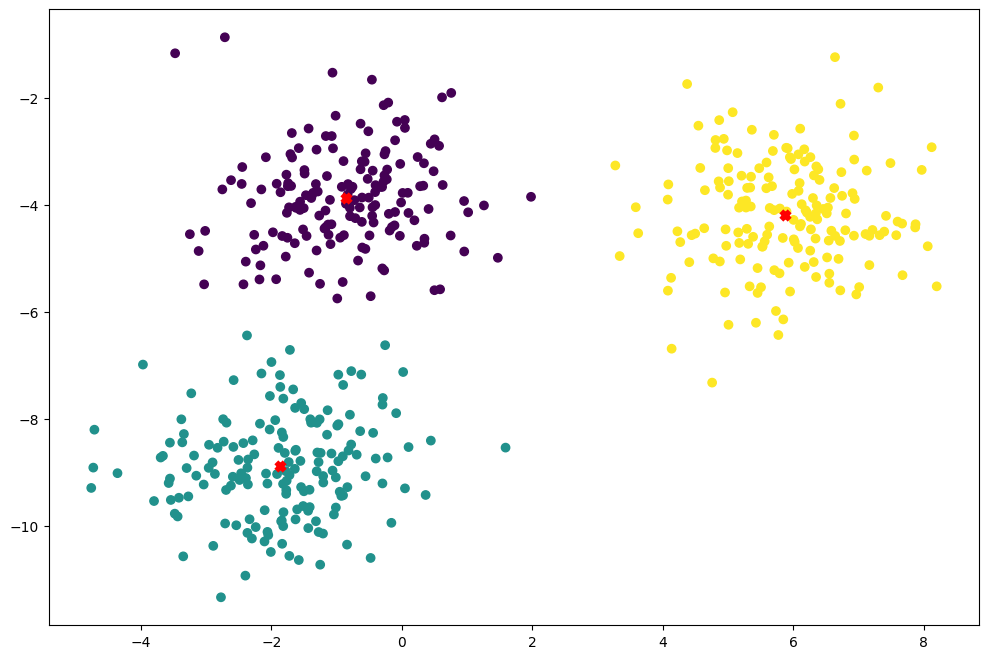

In [10]:
k = My_KMeans(k=clusters)
y_pred = k.fit(X,max_iters=200)
k.plot(X,y_pred)


In [11]:
adjusted_rand_score(y,y_pred)

0.988036532598244

In [12]:
k.calculate_inertia(X,y_pred)

974.1014168273969

In [13]:
calculate_silhouette_score(X,y_pred), silhouette_score(X,y_pred)

(0.6837082573916827, 0.6837082573916827)

In [17]:
calculate_dunn_index(X,y_pred)

0.14722827658559565

In [18]:
calculate_davis_bouldin_index(X,y_pred, k.centroids), davies_bouldin_score(X,y_pred)

(0.4380609999740101, 0.4380609999740095)

In [21]:
cluster_numbers = [2,3,4,5,6,7,8,9]
inertia = [] # measures how tight a cluster is (the greater the k the better the inertia so find the elbow)
silhouette_scores = [] # measures how far data points are from centers of other clusters (how well seperated are these clusters)
for k in cluster_numbers:
    my_kmeans = My_KMeans(k=k)
    pred = my_kmeans.fit(X, max_iters=200)
    inertia.append(my_kmeans.calculate_inertia(X,pred))
    silhouette_scores.append(calculate_silhouette_score(X,pred))


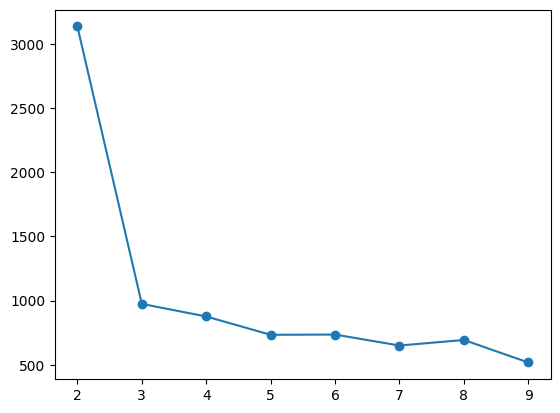

In [22]:
plt.plot(cluster_numbers,inertia, marker="o")

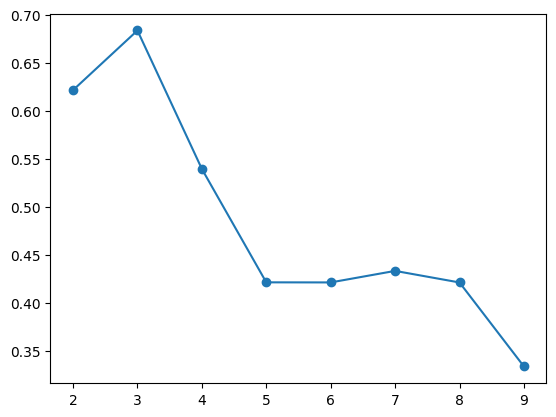

In [23]:
plt.plot(cluster_numbers,silhouette_scores, marker="o")

## Let's try out the kmeans++ initilaization

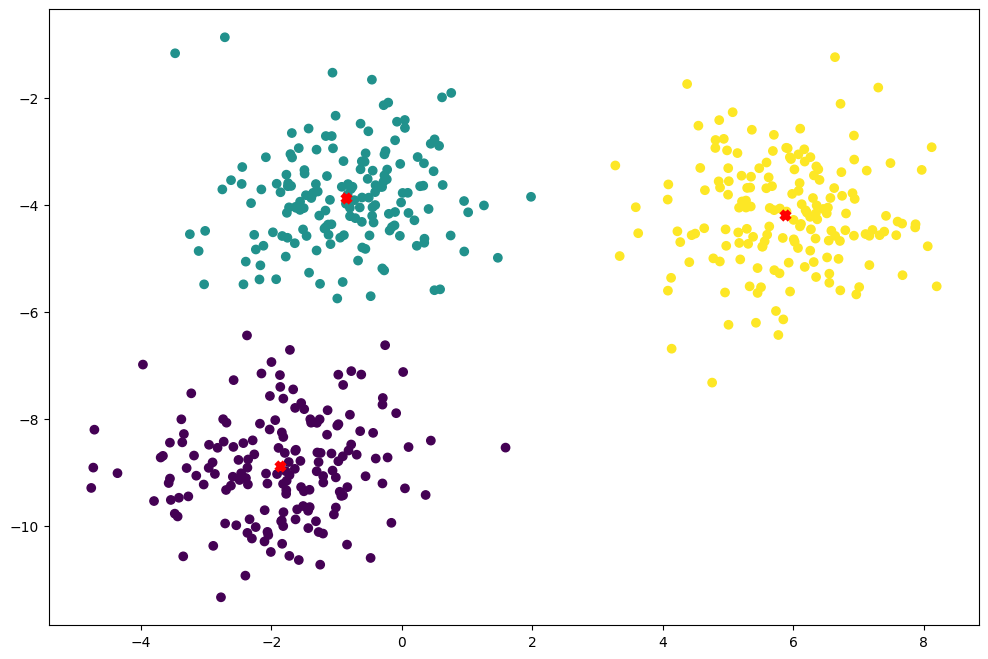

In [24]:
k_plus_plus = My_KMeans(k=clusters, initialize="kmeans++")
y_pred_2 = k_plus_plus.fit(X,max_iters=200)
k_plus_plus.plot(X,y_pred_2)

In [25]:
adjusted_rand_score(y,y_pred_2)

0.988036532598244

In [26]:
k_plus_plus.calculate_inertia(X,y_pred_2)

974.1014168273969

In [27]:
calculate_silhouette_score(X,y_pred_2), silhouette_score(X,y_pred_2)

(0.6837082573916827, 0.6837082573916827)

In [28]:
cluster_numbers = [2,3,4,5,6,7,8,9]
inertia = [] # measures how tight a cluster is (the greater the k the better the inertia so find the elbow)
silhouette_scores = [] # measures how far data points are from centers of other clusters (how well seperated are these clusters)
for k in cluster_numbers:
    my_kmeans_plus_plus = My_KMeans(k=k, initialize="kmeans++")
    pred = my_kmeans_plus_plus.fit(X, max_iters=200)
    inertia.append(my_kmeans_plus_plus.calculate_inertia(X,pred))
    silhouette_scores.append(calculate_silhouette_score(X,pred))


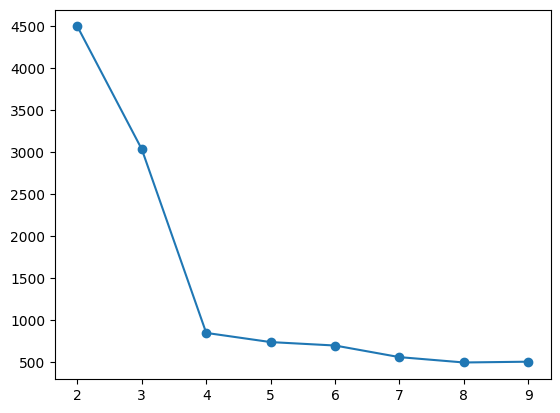

In [29]:
plt.plot(cluster_numbers,inertia, marker="o")

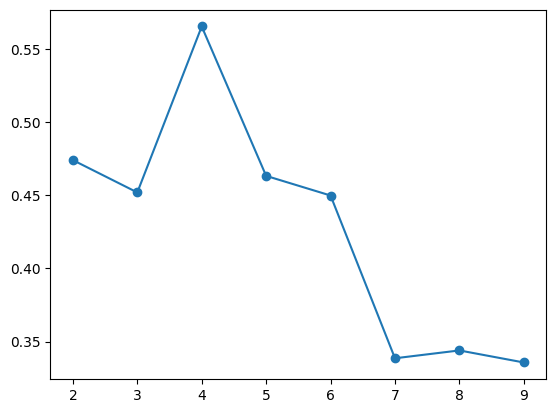

In [30]:
plt.plot(cluster_numbers,silhouette_scores, marker="o")

## Trying out predict function 

In [31]:
other =My_KMeans(k=3)
other.fit(X,max_iters=200)

array([0, 1, 2, 2, 1, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 2, 1, 1, 0, 2, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 2, 1, 0, 1, 2, 2, 0, 1, 2, 0, 0, 1, 0, 1, 1,
       2, 2, 2, 2, 1, 1, 2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 2, 0,
       0, 1, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1, 2, 0, 2, 2, 1, 2, 1, 0, 2,
       2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 2,
       2, 2, 1, 1, 1, 0, 1, 0, 0, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2,
       2, 2, 1, 0, 1, 2, 1, 1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 2,
       2, 2, 2, 0, 1, 2, 1, 0, 1, 0, 2, 0, 1, 1, 2, 2, 0, 1, 2, 2, 0, 2,
       2, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 0, 2, 0, 1, 2, 0, 0,
       2, 1, 2, 2, 2, 1, 1, 2, 2, 0, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 2,
       0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1,
       0, 1, 2, 2, 0, 1, 0, 0, 0, 2, 0, 2, 1, 2, 1, 2, 1, 0, 0, 2, 2, 2,
       1, 0, 0, 2, 2, 0, 1, 1, 0, 0, 0, 2, 1, 1, 2,

In [32]:
other.predict(np.array([[1,2],[102,103]]))

array([2, 1], dtype=int64)

# Sklearn

In [33]:
cluster_numbers = [2,3,4,5,6,7,8,9]

In [34]:
inertia = [] # measures how tight a cluster is (the greater the k the better the inertia so find the elbow)
silhouette_scores = [] # measures how far data points are from centers of other clusters (how well seperated are these clusters)
for k in cluster_numbers:
    sklearn_kmean = KMeans(n_clusters=k,random_state=40, n_init=10, init="k-means++")
    sklearn_kmean.fit(X)
    inertia.append(sklearn_kmean.inertia_)
    silhouette_scores.append(silhouette_score(X,sklearn_kmean.labels_))

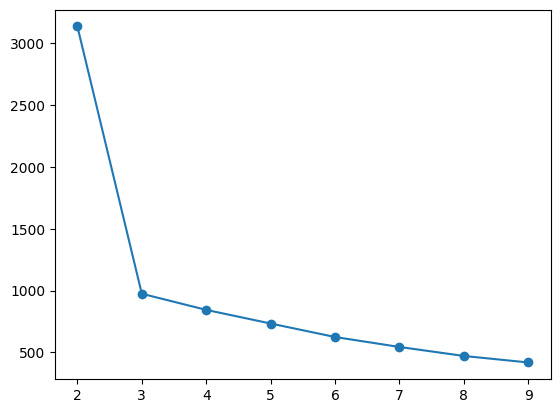

In [35]:
plt.plot(cluster_numbers,inertia, marker="o")

The elbow exists at k=3 so it seems that it is the best choice

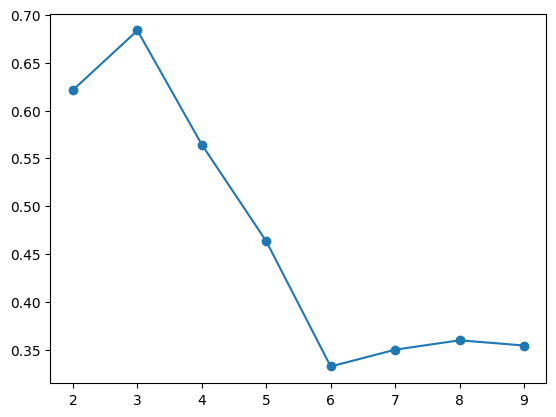

In [36]:
plt.plot(cluster_numbers,silhouette_scores, marker="o")

highest silhouette score is also at k=3